In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_lfw_people,fetch_olivetti_faces
import matplotlib.pyplot as plt


In [29]:
def pca(X, k):
    # Standardize the data
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std = np.where(X_std == 0, 1, X_std)  # avoid division by zero
    X_std = (X - X_mean) / X_std

    # Compute the covariance matrix
    cov_matrix = np.cov(X_std.T)  #cov = A^T * A

    # Compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)   

    # Sort the eigenvalues and corresponding eigenvectors
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # Select the top k eigenvectors
    top_k_eigenvectors = eigenvectors[:, :k]

    #   mapping back to origincal dataset
    X_pca = np.dot(X_std, top_k_eigenvectors)
    print(X_pca.shape)

    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues[:k] / np.sum(eigenvalues)

    return X_pca, explained_variance_ratio, top_k_eigenvectors, X_mean, X_std

In [30]:
def pca_transform(X, top_k_eigenvectors):
    # Standardize the data
    X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Project the data onto the new feature space
    X_pca = np.dot(X_std, top_k_eigenvectors)
    print(X_pca.shape)

    return X_pca

def pca_inverse_transform(X_pca, top_k_eigenvectors, X_mean, X_std):
    # Reconstruct the original data
    X_reconstructed = np.dot(X_pca, top_k_eigenvectors.T) * X_std + X_mean

    return X_reconstructed

In [31]:
# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# n_samples, h, w = lfw_people.images.shape
# X = lfw_people.data
# y = lfw_people.target
# target_names = lfw_people.target_names
# n_classes = target_names.shape[0]

olivetti_people = fetch_olivetti_faces()

# Get the shape of the images
n_samples, h, w = olivetti_people.images.shape

# Get the data
X = olivetti_people.data

# Get the target
y = olivetti_people.target

# Get the target names
target_names = np.array(["person_" + str(i) for i in range(40)])

# Get the number of classes
n_classes = target_names.shape[0]


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\moham\scikit_learn_data


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [33]:
# Compute PCA (eigenfaces) on the face dataset 
X_train_pca, explained_variance_ratio, top_k_eigenvectors, X_mean, X_std = pca(X_train, 150)
X_test_pca= pca(X_test, 150)



(300, 150)
(100, 150)


In [34]:
# Calculate the cumulative sum of explained variances


explained_variances = np.cumsum(explained_variance_ratio)


In [38]:
# Find the number of components that explain a certain percentage of the variance
percentages = [0.10, 0.15, 0.60,0.90]
n_components = [np.argmax(explained_variances >= p) + 1 for p in percentages]

(300, 1)
(300, 1)
(300, 8)
(300, 62)


c:\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


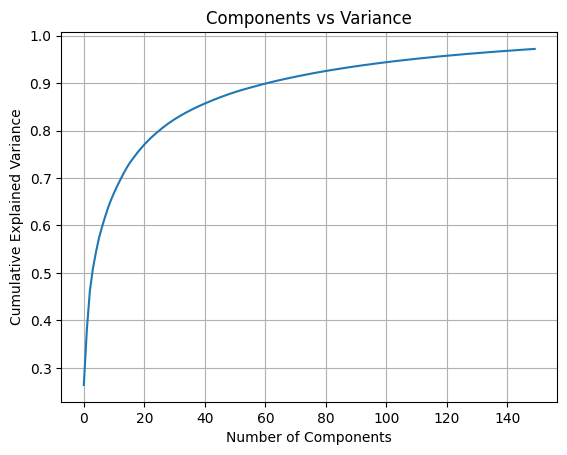

In [39]:
# Select the top k eigenfaces, project the training set onto the eigenfaces, and reconstruct the images
images_reconstructed = []
for n in n_components:
    X_train_pca = pca_transform(X_train, top_k_eigenvectors[:, :n])
    X_reconstructed = pca_inverse_transform(X_train_pca, top_k_eigenvectors[:, :n], X_mean, X_std)
    images_reconstructed.append(X_reconstructed)

# Plot the cumulative explained variances
plt.figure()
plt.plot(explained_variances)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Components vs Variance')
plt.grid(True)
plt.show()

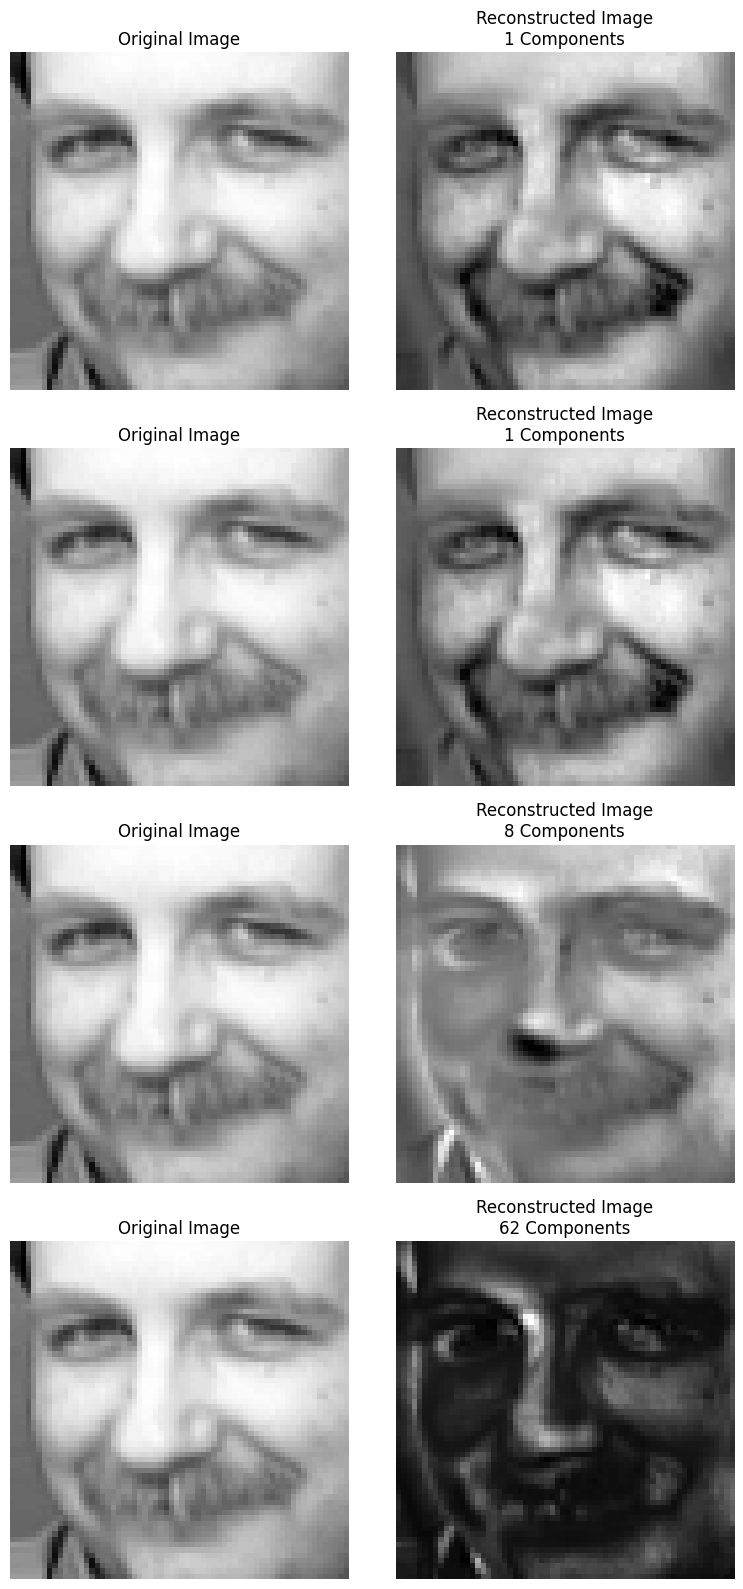

In [40]:
# Plot the original images and the reconstructed images
fig, ax = plt.subplots(len(n_components), 2, figsize=(8, 4 * len(n_components)))

for i, images in enumerate(images_reconstructed):
    ax[i, 0].imshow(X_train[0].reshape((h, w)), cmap=plt.cm.gray)
    ax[i, 0].set_title('Original Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(np.real(images[0].reshape((h, w))), cmap=plt.cm.gray)
    ax[i, 1].set_title(f'Reconstructed Image\n{n_components[i]} Components')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()